<center><h1>Chen_WeiChieh_Project</h1></center>

### Due to the high training time for this project and my 1st result of CNN+MLP is not good, I re-run the CNN+MLP model by adding a RandomFlip and a dense layer with 64 perceptrons. Hence, my work is divided into 2 files. This file pertains to "Transfer Learning" and the comparison of the models.

### Please only see transfer learning part in this file, and refer to the cell denoting "All the work of this file starts from here"

Name: WeiChieh, Chen
<br>
Github Username: raychencssw
<br>
USC ID: 6284920085

# 1

In [1]:
import os
import os.path as op
import json
from pathlib import Path
import shutil
import logging
import numpy as np
from tqdm import tqdm
from skimage import io


In [2]:
# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

# Head directory containing all image subframes. Update with the relative path of your data directory
data_head_dir = Path('./data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
#print(subdirs) 
#PosixPath('ESP_026602_1300_25600_30720_5120_10240'), ....

src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]
# print(src_image_ids)
#['ESP_026602_1300',

In [3]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('./train_source_images.txt')
validate_ids = load_text_ids('./val_source_images.txt')
test_ids = load_text_ids('./test_source_images.txt')

# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

# print(len(subdir_splits))  # 214
# print(subdir_splits)       # ['test', 'train', ...]

# Loading and pre processing the data
### Note that there are multiple ways to preprocess and load your data in order to train your model in tensorflow. We have provided one way to do it in the following cell. Feel free to use your own method and get better results.

In [4]:
import random
import tensorflow as tf
from PIL import Image 


def load_and_preprocess(img_loc, label):
    
    def _inner_function(img_loc, label):
        
        # Convert tensor to native type
        img_loc_str = img_loc.numpy().decode('utf-8')

        # Load image using PIL and convert to RGB
        img = Image.open(img_loc_str).convert('RGB')

        # Convert PIL image to numpy array
        img = np.array(img)
        img = tf.image.resize(img, [299, 299])

        # Normalize the image to the [0, 1] range
        img = img / 255.0
        # Convert label to integer (assuming binary classification)
        label = 1 if label.numpy().decode('utf-8') == 'frost' else 0

        return img, label

    # Wrap the Python function
    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])

    # Set the shape of the tensors
    X.set_shape([299, 299, 3])
    y.set_shape([]) # Scalar label
    
    return X, y

def load_subdir_data(dir_path, image_size, seed=None):
    
    """Helper to create a TF dataset from each image subdirectory"""
    # dir_path: ./data/ESP_026602_1300_25600_30720_5120_10240

    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    # tile_dir: ./data/ESP_026602_1300_25600_30720_5120_10240/tiles
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')
    
    loc_list = []
    
    # folder: frost or background
    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            # file: PSP_008120_2465_70447_70746_7811_8110.png
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    # (./data/ESP_026602_1300_25600_30720_5120_10240/tiles/frost/PSP_008120_2465_70447_70746_7811_8110.png, frost)
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))

    return loc_list

# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements

# 12/6 23:00 exp
buffer_size = 64         #11s
batch_size = 32


# buffer_size = 119920   #75m
# batch_size = 128

# buffer_size = 256        #47m
# batch_size = 128

# subdirs: PosixPath('ESP_026602_1300_25600_30720_5120_10240'), ....
# subdir_splits: ['test', 'train', ...]  len:214
for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))

# training data        

random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)
#print(img_list_t)
#tf.Tensor([b'data/PSP_008120_2465_66560_71680_5120_10240/tiles/frost/PSP_008120_2465_69849_70148_9306_9605.png']..., shape=(14119,), dtype=string)


tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
# print(tf_dataset_train)

# tf.data.experimental.AUTOTUNE: representing the number elements to process asynchronously in parallel
# load_and_preprocess: converts the label to a binary format (1 if 'frost', 0 otherwise)
tf_dataset_train = tf_dataset_train.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# tf_dataset_train = tf_dataset_train.map(rotate_train)
# print(len(list(tf_dataset_train))) # 14119
# print(tf_dataset_train)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size) 
# print(len(list(tf_dataset_train))) # 442
# print(tf_dataset_train)

# validation data 

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# print(len(list(tf_dataset_val))) # 7889
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size) 
# print(len(list(tf_dataset_val))) # 247

# test data 

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_test)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# len(list(tf_dataset_test))
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size) 
# len(list(tf_dataset_test)) # 250

00:20:28 | INFO  | utils           | NumExpr defaulting to 8 threads.


In [5]:
for img, label in tf_dataset_train.take(1):
    print(img.shape)
    print(img[0][0][0])
    print(len(label))
    print(label)

(32, 299, 299, 3)
tf.Tensor([0.21568628 0.21568628 0.21568628], shape=(3,), dtype=float32)
32
tf.Tensor([1 0 0 0 0 1 1 0 1 1 0 1 0 1 1 1 1 0 1 0 0 1 1 1 1 0 1 1 0 0 0 1], shape=(32,), dtype=int64)


# Traning CNN + MLP
### i Empirical Regularization

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout, Conv2D, MaxPooling2D, Flatten, RandomRotation
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from keras.models import Model
import matplotlib.pyplot as plt

### ii Train a three-layer CNN

In [90]:
def build_cnn():
    # Define the model
    model = Sequential()

    # Convolutional layers
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(299,299,3), padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(RandomRotation(factor=(-1,1),seed=SEED))

    model.add(Flatten())

    # Add the output layer with softmax activation
    model.add(Dense(2, activation='softmax'))

    # Compile the model
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


    return model

model = build_cnn()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(tf_dataset_train, epochs=25, validation_data=tf_dataset_val, callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(tf_dataset_test)

print(f'Test accuracy: {test_acc}')


# 415m

23:47:57 | WARNING | optimizer       | At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.


Epoch 1/20
111/111 [==============================] - 1091s 10s/step - loss: 4.8668 - accuracy: 0.8235 - val_loss: 9.4205 - val_accuracy: 0.7886
Epoch 2/20


2023-12-07 00:06:18.889802: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:193: Filling up shuffle buffer (this may take a while): 11975 of 119920
2023-12-07 00:06:20.923543: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


111/111 [==============================] - 1318s 12s/step - loss: 3.1188 - accuracy: 0.8672 - val_loss: 10.5932 - val_accuracy: 0.7982
Epoch 3/20


2023-12-07 00:28:16.905505: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:193: Filling up shuffle buffer (this may take a while): 11718 of 119920
2023-12-07 00:28:19.487848: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


111/111 [==============================] - 1293s 12s/step - loss: 2.8478 - accuracy: 0.8893 - val_loss: 68.6483 - val_accuracy: 0.2320
Epoch 4/20


2023-12-07 00:49:49.997548: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:193: Filling up shuffle buffer (this may take a while): 12111 of 119920
2023-12-07 00:49:52.059755: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


111/111 [==============================] - 1259s 11s/step - loss: 2.6742 - accuracy: 0.8748 - val_loss: 6.4991 - val_accuracy: 0.8377
Epoch 5/20


2023-12-07 01:10:48.849729: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:193: Filling up shuffle buffer (this may take a while): 12555 of 119920
2023-12-07 01:10:50.264797: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


111/111 [==============================] - 1259s 11s/step - loss: 4.6827 - accuracy: 0.8773 - val_loss: 10.7762 - val_accuracy: 0.7900
Epoch 6/20


2023-12-07 01:31:48.059362: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:193: Filling up shuffle buffer (this may take a while): 12536 of 119920
2023-12-07 01:31:49.529393: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


111/111 [==============================] - 1228s 11s/step - loss: 2.2908 - accuracy: 0.8904 - val_loss: 7.8039 - val_accuracy: 0.8895
Epoch 7/20


2023-12-07 01:52:16.527916: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:193: Filling up shuffle buffer (this may take a while): 12743 of 119920
2023-12-07 01:52:18.355504: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


111/111 [==============================] - 1255s 11s/step - loss: 3.0447 - accuracy: 0.8906 - val_loss: 4.1378 - val_accuracy: 0.9067
Epoch 8/20


2023-12-07 02:13:11.545460: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:193: Filling up shuffle buffer (this may take a while): 11856 of 119920
2023-12-07 02:13:13.711635: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


111/111 [==============================] - 1250s 11s/step - loss: 2.1103 - accuracy: 0.9162 - val_loss: 4.0738 - val_accuracy: 0.9229
Epoch 9/20


2023-12-07 02:34:01.439489: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:193: Filling up shuffle buffer (this may take a while): 12201 of 119920
2023-12-07 02:34:03.970545: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


111/111 [==============================] - 1236s 11s/step - loss: 2.0261 - accuracy: 0.9178 - val_loss: 3.4776 - val_accuracy: 0.7123
Epoch 10/20


2023-12-07 02:54:37.444238: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:193: Filling up shuffle buffer (this may take a while): 13092 of 119920
2023-12-07 02:54:38.354923: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


111/111 [==============================] - 1254s 11s/step - loss: 2.1110 - accuracy: 0.9210 - val_loss: 2.7761 - val_accuracy: 0.8223
Epoch 11/20


2023-12-07 03:15:31.407617: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:193: Filling up shuffle buffer (this may take a while): 11140 of 119920
2023-12-07 03:15:34.557153: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


111/111 [==============================] - 1250s 11s/step - loss: 1.3834 - accuracy: 0.9373 - val_loss: 2.5980 - val_accuracy: 0.8963
Epoch 12/20


2023-12-07 03:36:21.414840: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:193: Filling up shuffle buffer (this may take a while): 12579 of 119920
2023-12-07 03:36:22.831095: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


111/111 [==============================] - 1269s 11s/step - loss: 1.2090 - accuracy: 0.9479 - val_loss: 2.3440 - val_accuracy: 0.9395
Epoch 13/20


2023-12-07 03:57:30.396595: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:193: Filling up shuffle buffer (this may take a while): 11899 of 119920
2023-12-07 03:57:32.495541: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


111/111 [==============================] - 1243s 11s/step - loss: 1.7555 - accuracy: 0.9413 - val_loss: 14.1503 - val_accuracy: 0.6812
Epoch 14/20


2023-12-07 04:18:13.357163: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:193: Filling up shuffle buffer (this may take a while): 11726 of 119920
2023-12-07 04:18:15.817601: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


111/111 [==============================] - 1232s 11s/step - loss: 2.3163 - accuracy: 0.9059 - val_loss: 2.2594 - val_accuracy: 0.9128
Epoch 15/20


2023-12-07 04:38:45.693849: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:193: Filling up shuffle buffer (this may take a while): 13020 of 119920
2023-12-07 04:38:46.768723: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


111/111 [==============================] - 1178s 11s/step - loss: 1.9723 - accuracy: 0.9319 - val_loss: 4.4052 - val_accuracy: 0.8686
Epoch 16/20


2023-12-07 04:58:23.395281: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:193: Filling up shuffle buffer (this may take a while): 13037 of 119920
2023-12-07 04:58:24.354090: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


111/111 [==============================] - 1254s 11s/step - loss: 1.5295 - accuracy: 0.9460 - val_loss: 3.6375 - val_accuracy: 0.7536
Epoch 17/20


2023-12-07 05:19:16.907267: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:193: Filling up shuffle buffer (this may take a while): 10679 of 119920
2023-12-07 05:19:20.181509: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


111/111 [==============================] - 1230s 11s/step - loss: 1.4962 - accuracy: 0.9204 - val_loss: 42.5968 - val_accuracy: 0.2405
Epoch 18/20


2023-12-07 05:39:47.116076: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:193: Filling up shuffle buffer (this may take a while): 12708 of 119920
2023-12-07 05:39:48.417703: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


111/111 [==============================] - 1211s 11s/step - loss: 2.0396 - accuracy: 0.9034 - val_loss: 5.2318 - val_accuracy: 0.7711
Epoch 19/20


2023-12-07 05:59:57.995319: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:193: Filling up shuffle buffer (this may take a while): 12421 of 119920
2023-12-07 05:59:59.651456: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


111/111 [==============================] - 1212s 11s/step - loss: 1.0687 - accuracy: 0.9416 - val_loss: 1.5586 - val_accuracy: 0.9105
Epoch 20/20


2023-12-07 06:20:09.748930: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:193: Filling up shuffle buffer (this may take a while): 11140 of 119920
2023-12-07 06:20:13.464771: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


63/63 [==============================] - 148s 2s/step - loss: 8.0187 - accuracy: 0.4560
Test accuracy: 0.4559708833694458


In [91]:
# Save the entire model to a file
model.save('model.h5')

# Save only the weights to a separate file
model.save_weights('weights.h5')

/Users/Ray/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [92]:
# print(model.summary())

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_56 (Conv2D)          (None, 299, 299, 32)      896       
                                                                 
 batch_normalization_59 (Ba  (None, 299, 299, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_55 (MaxPooli  (None, 149, 149, 32)      0         
 ng2D)                                                           
                                                                 
 dropout_57 (Dropout)        (None, 149, 149, 32)      0         
                                                                 
 conv2d_57 (Conv2D)          (None, 149, 149, 64)      18496     
                                                                 
 batch_normalization_60 (Ba  (None, 149, 149, 64)    

### iii Report Precision, Recall, and F1-score

In [93]:
# model.predict_classes is deprecated
y_pred = model.predict(tf_dataset_test)

63/63 [==============================] - 148s 2s/step


In [94]:
# convert the predicted probability to predicted class
y_pred_class = np.argmax(y_pred, axis=1)
print(len(y_pred_class))
print(y_pred_class)

# extract the true label from the batched dataset
y_true = []
for img, labels in tf_dataset_test:
    # print(label)
    for label in labels:
        y_true.append(label)
print(len(y_true))

7972
[0 0 0 ... 1 0 0]
7972


In [95]:
report = classification_report(y_true, y_pred_class)
print(report)

              precision    recall  f1-score   support

           0       0.28      0.82      0.42      2198
           1       0.73      0.19      0.30      5774

    accuracy                           0.36      7972
   macro avg       0.51      0.50      0.36      7972
weighted avg       0.61      0.36      0.33      7972



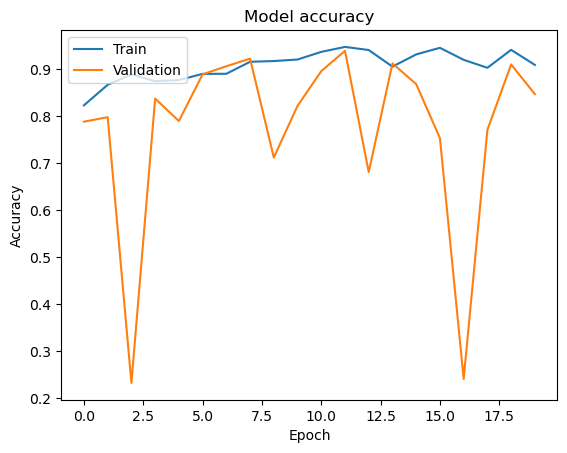

In [96]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

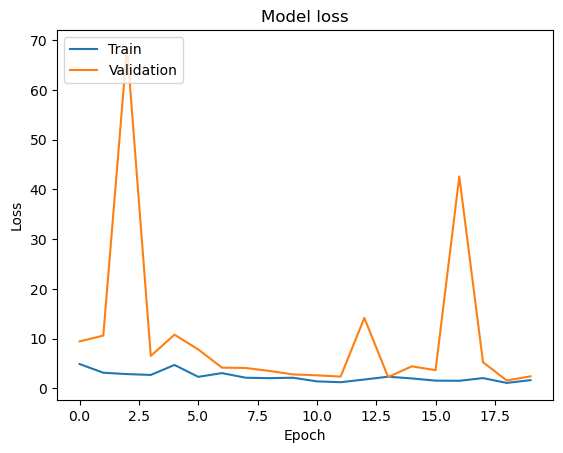

In [97]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### All the work of this file starts from here

# Transfer Learning

### EfficientNetB0

In [7]:
from keras.applications.efficientnet import EfficientNetB0, preprocess_input

In [8]:
#build a EfficientNetB0 without top layer and freeze the feature extraction layers
model_eff = EfficientNetB0(include_top=False, input_shape = (299,299,3))
for layer in model_eff.layers:
    layer.trainable = False

# model_eff.summary()

In [9]:

model_eff_retrain = Sequential()

model_eff_retrain.add(model_eff)   

output_shape = model_eff_retrain.output_shape
print(output_shape)

model_eff_retrain.add(RandomRotation(factor=(-1,1),seed=SEED))

output_shape = model_eff_retrain.output_shape
print(output_shape)

model_eff_retrain.add(Flatten())

output_shape = model_eff_retrain.output_shape
print(output_shape)


model_eff_retrain.add(Dense(64, activation='relu'))
model_eff_retrain.add(BatchNormalization())
model_eff_retrain.add(Dropout(0.3))

model_eff_retrain.add(Dense(2, activation='softmax'))

model_eff_retrain.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping_eff = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_eff = model_eff_retrain.fit(tf_dataset_train, epochs=15, validation_data=tf_dataset_val, callbacks=[early_stopping_eff])


# 92m(7 epochs)

(None, 10, 10, 1280)
(None, 10, 10, 1280)
(None, 128000)
Epoch 1/15
442/442 [==============================] - ETA: 0s - loss: 0.7190 - accuracy: 0.6008

2023-12-08 00:27:56.062990: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:6: Filling up shuffle buffer (this may take a while): 54 of 64
2023-12-08 00:27:57.140814: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


442/442 [==============================] - 1485s 3s/step - loss: 0.7190 - accuracy: 0.6008 - val_loss: 1.6174 - val_accuracy: 0.2310
Epoch 2/15
442/442 [==============================] - 595s 1s/step - loss: 0.6616 - accuracy: 0.6381 - val_loss: 0.7626 - val_accuracy: 0.2310
Epoch 3/15
442/442 [==============================] - 649s 1s/step - loss: 0.6519 - accuracy: 0.6481 - val_loss: 1.0221 - val_accuracy: 0.2310
Epoch 4/15
442/442 [==============================] - 695s 2s/step - loss: 0.6491 - accuracy: 0.6507 - val_loss: 0.8891 - val_accuracy: 0.2310
Epoch 5/15
442/442 [==============================] - 693s 2s/step - loss: 0.6483 - accuracy: 0.6503 - val_loss: 0.8499 - val_accuracy: 0.2310
Epoch 6/15
442/442 [==============================] - 701s 2s/step - loss: 0.6474 - accuracy: 0.6507 - val_loss: 1.0667 - val_accuracy: 0.2310
Epoch 7/15
442/442 [==============================] - 699s 2s/step - loss: 0.6471 - accuracy: 0.6498 - val_loss: 1.0485 - val_accuracy: 0.2310


In [10]:
# Save the entire model to a file
model_eff_retrain.save('model_eff.h5')

# Save only the weights to a separate file
model_eff_retrain.save_weights('weights_eff.h5')

/Users/Ray/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
# model.predict_classes is deprecated
y_pred_eff = model_eff_retrain.predict(tf_dataset_test)

# convert the predicted probability to predicted class
y_pred_eff_class = np.argmax(y_pred_eff, axis=1)
print(len(y_pred_eff_class))
print(y_pred_eff_class)

# extract the true label from the batched dataset
y_true = []
for img, labels in tf_dataset_test:
    # print(label)
    for label in labels:
        y_true.append(label)
print(len(y_true))


#30m

2023-12-08 01:53:56.846005: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 53 of 64
2023-12-08 01:53:58.503103: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - 1642s 7s/step
7972
[1 1 1 ... 1 1 1]


2023-12-08 02:21:19.033521: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 62 of 64
2023-12-08 02:21:19.034577: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


7972


In [12]:
report_eff = classification_report(y_true, y_pred_eff_class)
print(report_eff)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2198
           1       0.72      1.00      0.84      5774

    accuracy                           0.72      7972
   macro avg       0.36      0.50      0.42      7972
weighted avg       0.52      0.72      0.61      7972



/Users/Ray/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Ray/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Ray/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [47]:
# Evaluate the model on the test set
test_loss_eff, test_acc_eff = model_eff_retrain.evaluate(tf_dataset_test)

print(f'Test accuracy: {test_acc_eff}')

250/250 [==============================] - 192s 768ms/step - loss: 0.6513 - accuracy: 0.7243
Test accuracy: 0.7242850065231323


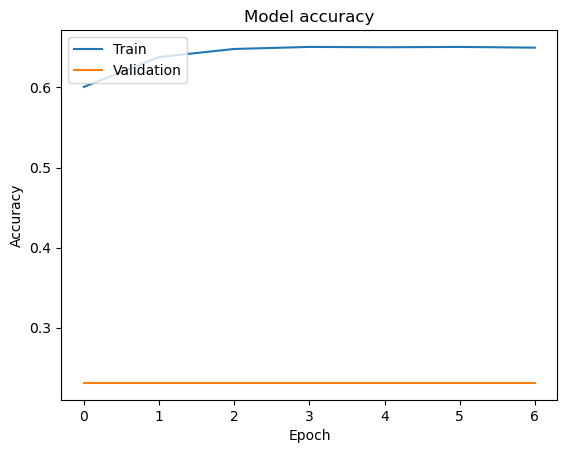

In [13]:
plt.plot(history_eff.history['accuracy'])
plt.plot(history_eff.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

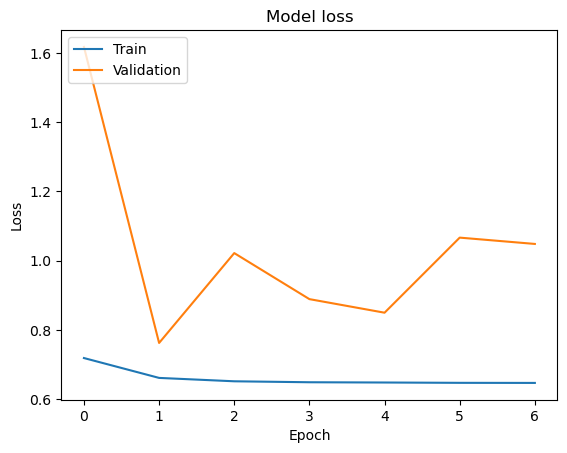

In [14]:
plt.plot(history_eff.history['loss'])
plt.plot(history_eff.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### ResNet50

In [23]:
from keras.applications import ResNet50

In [24]:
#build a ResNet50 without top layer and freeze the feature extraction layers
model_res = ResNet50(include_top=False, input_shape = (299,299,3))
for layer in model_res.layers:
    layer.trainable = False

In [27]:
model_res_retrain = Sequential()

model_res_retrain.add(model_res)   

model_res_retrain.add(RandomRotation(factor=(-1,1),seed=SEED))

model_res_retrain.add(Flatten())

model_res_retrain.add(Dense(64, activation='relu'))
model_res_retrain.add(BatchNormalization())
model_res_retrain.add(Dropout(0.3))

model_res_retrain.add(Dense(2, activation='softmax'))

model_res_retrain.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping_res = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_res = model_res_retrain.fit(tf_dataset_train, epochs=15, validation_data=tf_dataset_val, callbacks=[early_stopping_res])


#202m(6 epochs)

Epoch 1/15
442/442 [==============================] - 1980s 4s/step - loss: 0.5972 - accuracy: 0.7044 - val_loss: 0.4499 - val_accuracy: 0.8063
Epoch 2/15
442/442 [==============================] - 2130s 5s/step - loss: 0.4598 - accuracy: 0.7832 - val_loss: 0.7735 - val_accuracy: 0.5236
Epoch 3/15
442/442 [==============================] - 1960s 4s/step - loss: 0.4035 - accuracy: 0.8222 - val_loss: 0.6398 - val_accuracy: 0.6503
Epoch 4/15
442/442 [==============================] - 2169s 5s/step - loss: 0.3747 - accuracy: 0.8389 - val_loss: 0.5888 - val_accuracy: 0.6901
Epoch 5/15
442/442 [==============================] - 1991s 5s/step - loss: 0.3608 - accuracy: 0.8466 - val_loss: 0.7811 - val_accuracy: 0.5619
Epoch 6/15
442/442 [==============================] - 1909s 4s/step - loss: 0.3386 - accuracy: 0.8559 - val_loss: 0.8069 - val_accuracy: 0.5486


In [28]:
# Save the entire model to a file
model_res_retrain.save('model_res.h5')

# Save only the weights to a separate file
model_res_retrain.save_weights('weights_res.h5')

/Users/Ray/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [29]:
# model.predict_classes is deprecated
y_pred_res = model_res_retrain.predict(tf_dataset_test)

# convert the predicted probability to predicted class
y_pred_res_class = np.argmax(y_pred_res, axis=1)
print(len(y_pred_res_class))
print(y_pred_res_class)

# extract the true label from the batched dataset
y_true = []
for img, labels in tf_dataset_test:
    # print(label)
    for label in labels:
        y_true.append(label)
print(len(y_true))

#12m

250/250 [==============================] - 678s 3s/step
7972
[0 1 1 ... 0 0 1]
7972


In [30]:
report_res = classification_report(y_true, y_pred_res_class)
print(report_res)

              precision    recall  f1-score   support

           0       0.28      0.69      0.40      2198
           1       0.73      0.31      0.44      5774

    accuracy                           0.42      7972
   macro avg       0.50      0.50      0.42      7972
weighted avg       0.60      0.42      0.43      7972



In [45]:
# Evaluate the model on the test set
test_loss_res, test_acc_res = model_res_retrain.evaluate(tf_dataset_test)

print(f'Test accuracy: {test_acc_res}')

250/250 [==============================] - 707s 3s/step - loss: 1.0901 - accuracy: 0.4024
Test accuracy: 0.4024084210395813


In [46]:
print(f'Test accuracy: {test_acc_res}')

Test accuracy: 0.4024084210395813


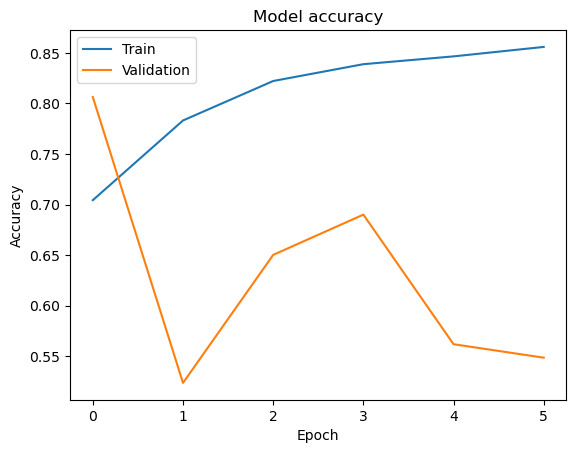

In [31]:
plt.plot(history_res.history['accuracy'])
plt.plot(history_res.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

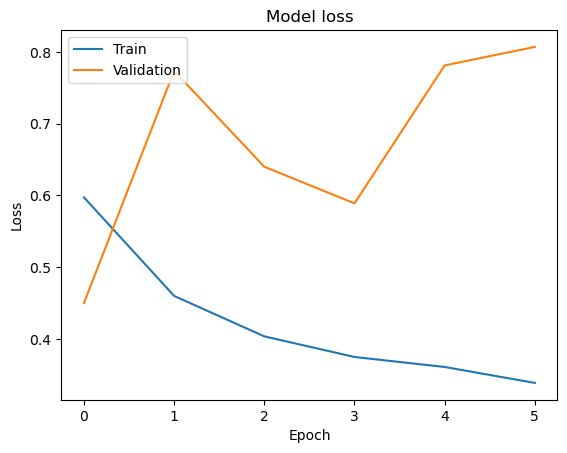

In [32]:
plt.plot(history_res.history['loss'])
plt.plot(history_res.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### VGG16

In [33]:
from keras.applications import VGG16

In [34]:
#build a VGG16 without top layer and freeze the feature extraction layers
model_vgg = VGG16(include_top=False, input_shape = (299,299,3))
for layer in model_vgg.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 2s 0us/step


In [35]:
model_vgg_retrain = Sequential()

model_vgg_retrain.add(model_vgg)   

model_vgg_retrain.add(RandomRotation(factor=(-1,1),seed=SEED))

model_vgg_retrain.add(Flatten())

model_vgg_retrain.add(Dense(64, activation='relu'))
model_vgg_retrain.add(BatchNormalization())
model_vgg_retrain.add(Dropout(0.3))

model_vgg_retrain.add(Dense(2, activation='softmax'))

model_vgg_retrain.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping_vgg = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_vgg = model_vgg_retrain.fit(tf_dataset_train, epochs=15, validation_data=tf_dataset_val, callbacks=[early_stopping_vgg])



Epoch 1/15
442/442 [==============================] - 5810s 13s/step - loss: 0.1015 - accuracy: 0.9641 - val_loss: 2.6354 - val_accuracy: 0.4633
Epoch 2/15
442/442 [==============================] - 5787s 13s/step - loss: 0.0560 - accuracy: 0.9785 - val_loss: 2.1241 - val_accuracy: 0.5586
Epoch 3/15
442/442 [==============================] - 5751s 13s/step - loss: 0.0441 - accuracy: 0.9840 - val_loss: 1.2508 - val_accuracy: 0.6775
Epoch 4/15
442/442 [==============================] - 5728s 13s/step - loss: 0.0479 - accuracy: 0.9831 - val_loss: 2.2301 - val_accuracy: 0.4830
Epoch 5/15
442/442 [==============================] - 5770s 13s/step - loss: 0.0398 - accuracy: 0.9856 - val_loss: 2.1632 - val_accuracy: 0.5226
Epoch 6/15
442/442 [==============================] - 6486s 15s/step - loss: 0.0340 - accuracy: 0.9880 - val_loss: 2.4086 - val_accuracy: 0.4987
Epoch 7/15
442/442 [==============================] - 6655s 15s/step - loss: 0.0394 - accuracy: 0.9865 - val_loss: 2.4220 - val_ac

In [36]:
# Save the entire model to a file
model_vgg_retrain.save('model_vgg.h5')

# Save only the weights to a separate file
model_vgg_retrain.save_weights('weights_vgg.h5')

/Users/Ray/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [37]:
# model.predict_classes is deprecated
y_pred_vgg = model_vgg_retrain.predict(tf_dataset_test)

# convert the predicted probability to predicted class
y_pred_vgg_class = np.argmax(y_pred_vgg, axis=1)
print(len(y_pred_vgg_class))
print(y_pred_vgg_class)

# extract the true label from the batched dataset
y_true = []
for img, labels in tf_dataset_test:
    # print(label)
    for label in labels:
        y_true.append(label)
print(len(y_true))

250/250 [==============================] - 2755s 11s/step
7972
[0 1 1 ... 1 1 1]
7972


In [38]:
report_vgg = classification_report(y_true, y_pred_vgg_class)
print(report_vgg)

              precision    recall  f1-score   support

           0       0.29      0.38      0.33      2198
           1       0.73      0.64      0.68      5774

    accuracy                           0.57      7972
   macro avg       0.51      0.51      0.50      7972
weighted avg       0.61      0.57      0.58      7972



In [81]:
# Evaluate the model on the test set
test_loss_vgg, test_acc_vgg = model_vgg_retrain.evaluate(tf_dataset_test)

print(f'Test accuracy: {test_acc_vgg}')

# 05m

2023-12-10 12:48:03.667033: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 52 of 64
2023-12-10 12:48:04.919992: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - 2996s 12s/step - loss: 0.7027 - accuracy: 0.8258
Test accuracy: 0.8257651925086975


In [44]:
print(f'Test accuracy: {test_acc_vgg}')

Test accuracy: 0.8257651925086975


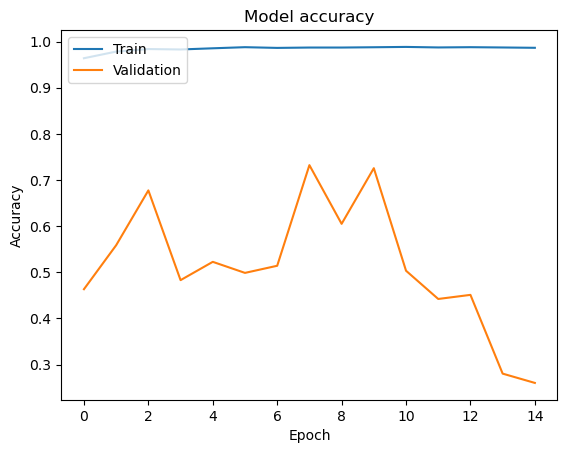

In [39]:
plt.plot(history_vgg.history['accuracy'])
plt.plot(history_vgg.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

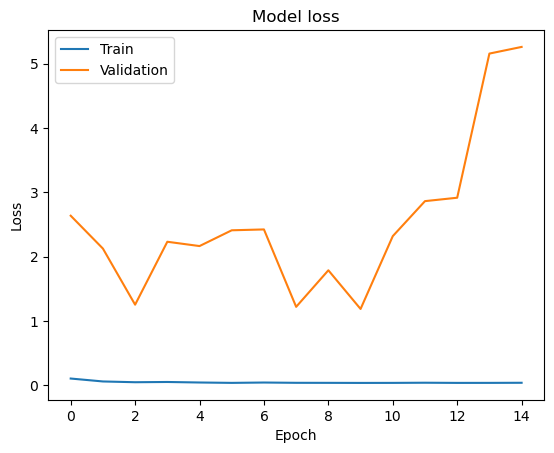

In [40]:
plt.plot(history_vgg.history['loss'])
plt.plot(history_vgg.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Summary of the models:
- EfficientNetB0 predict every observation as class 1 so it has the worst recall precision for calss 0.
- VGG16 gives the highest test acc while retain OK precision, recall and f1-score.
- None of the models perform well on class 0.
- These pre-trained model use 3 channels, but our data only use 1 channel. Such difference might casue some issue.
- Our handmade CNN+MLP model doesn't work well either, it can result from not many data augmentation and I don't use too many neurons.

In [78]:
def summary_models(reports, test_accs):
    precision = []
    recall = []
    f1_score = []
    test_acc = []

    # manually append CNN+MLP's result
    precision.append(0.28)
    precision.append(0.73)
    recall.append(0.82)
    recall.append(0.19)
    f1_score.append(0.42)
    f1_score.append(0.3)
    test_acc.append(0.4559708833694458)
    test_acc.append(0.4559708833694458)

    for report in reports:
        precision_0 = report.split()[5]
        precision_1 = report.split()[10]
        recall_0 = report.split()[6]
        recall_1 = report.split()[11]
        f1_0 = report.split()[7]
        f1_1 = report.split()[12]
        precision.append(precision_0)
        precision.append(precision_1)
        recall.append(recall_0)
        recall.append(recall_1)
        f1_score.append(f1_0)
        f1_score.append(f1_1)

    for acc in test_accs:
        test_acc.append(acc)
        test_acc.append(acc)
    summary = {'precision':precision, 'recall': recall, 'f1-score': f1_score, 'test_acc':test_acc}
    return summary


In [82]:
import pandas as pd
test_accs = [test_acc_eff, test_acc_res, test_acc_vgg]
reports = [report_eff,report_res,report_vgg]
summary = summary_models(reports, test_accs)
print(summary)
index = ['CNN+MLP_class0', 'CNN+MLP_class1','EfficientNetB0_clas0', 'EfficientNetB0_clas1', 'ResNet50_clas0', 'ResNet50_clas1', 'VGG16_clas0', 'VGG16_clas1']
df = pd.DataFrame(summary, index=index)
df

{'precision': [0.28, 0.73, '0.00', '0.72', '0.28', '0.73', '0.29', '0.73'], 'recall': [0.82, 0.19, '0.00', '1.00', '0.69', '0.31', '0.38', '0.64'], 'f1-score': [0.42, 0.3, '0.00', '0.84', '0.40', '0.44', '0.33', '0.68'], 'test_acc': [0.4559708833694458, 0.4559708833694458, 0.7242850065231323, 0.7242850065231323, 0.4024084210395813, 0.4024084210395813, 0.8257651925086975, 0.8257651925086975]}


,precision,recall,f1-score,test_acc
CNN+MLP_class0,0.28,0.82,0.42,0.455971
CNN+MLP_class1,0.73,0.19,0.3,0.455971
EfficientNetB0_clas0,0.00,0.00,0.00,0.724285
EfficientNetB0_clas1,0.72,1.00,0.84,0.724285
ResNet50_clas0,0.28,0.69,0.40,0.402408
ResNet50_clas1,0.73,0.31,0.44,0.402408
VGG16_clas0,0.29,0.38,0.33,0.825765
VGG16_clas1,0.73,0.64,0.68,0.825765


- Please notice that the rest accuracy of CNN+MLP is increased to 0.774 by adding RandomFlip layer and a dense layer with 64 perceptrons(refer to Chen_Wei_Chieh_Project.ipynb).